This Jupyter Notebook shows how our group reanalyzed publically available TAPS + BS-Seq data, performed on mESCs. 

Liu Y, Siejka-Zielińska P, Velikova G, Bi Y et al. Bisulfite-free direct detection of 5-methylcytosine and 5-hydroxymethylcytosine at base resolution. Nat Biotechnol 2019 Apr;37(4):424-429. PMID: 30804537

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE112520

In [1]:
#tidyverse
library(tidyr)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
#read all files from TAPS and TAPSb manuscripts. Only used TAPS since this is most comparable to BS (5mC + 5hmC)
file_BS_raw <- read.csv('GSM3071998_WGBS_mm9_CpG_blk.bed',header=FALSE,sep='\t')
file_TAPS_raw <- read.csv('GSM3454335_TAPS_mm9_CpG_blk.bed',header=FALSE,sep='\t')
file_TAPSb_raw <- read.csv('GSM4708553_tapsbeta_mm9_mESC_CpG.bed',header=FALSE,sep='\t')

In [3]:
#make dataframes
data_BS_raw <- tbl_df(file_BS_raw)
data_TAPS_raw <- tbl_df(file_TAPS_raw)
data_TAPSb_raw <- tbl_df(file_TAPSb_raw)

Warning message:
“`tbl_df()` was deprecated in dplyr 1.0.0.
Please use `tibble::as_tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”

In [4]:
#calculate coverage
#calculate percent mod
#remove NA
data_BS_raw <- data_BS_raw %>% mutate (V7 = V5 + V6)
data_BS_raw <- data_BS_raw %>% mutate (percent_mod = 100* V5 / V7) 
data_BS_raw <- na.omit(data_BS_raw)

In [5]:
#calculate coverage
#calculate percent mod
#remove NA
data_TAPS_raw <- data_TAPS_raw %>% mutate (V7 = V5 + V6)
data_TAPS_raw <- data_TAPS_raw %>% mutate (percent_mod = 100* V5 / V7) #this is percent mod not percent C
data_TAPS_raw <- na.omit(data_TAPS_raw)

In [6]:
#calculate coverage
#calculate percent mod
#remove NA
data_TAPSb_raw <- data_TAPSb_raw %>% mutate (V7 = V5 + V6)
data_TAPSb_raw <- data_TAPSb_raw %>% mutate (percent_mod = 100* V5 / V7) #this is percent mod not percent C
data_TAPSb_raw <- na.omit(data_TAPSb_raw)

In [7]:
#create 1kb bins, non-overlapping
data_BS_raw <- data_BS_raw %>% group_by(V1) %>% mutate(bin_1000 = cut_interval(V2, length=1000))
data_TAPS_raw <- data_TAPS_raw %>% group_by(V1) %>% mutate(bin_1000 = cut_interval(V2, length=1000))
data_TAPSb_raw <- data_TAPSb_raw %>% group_by(V1) %>% mutate(bin_1000 = cut_interval(V2, length=1000))

In [8]:
#calculate binned percent mod
data_BS_raw <- data_BS_raw %>% group_by(V1,bin_1000) %>% summarise(mean(percent_mod),sum(V5+V6))
data_TAPS_raw <- data_TAPS_raw %>% group_by(V1,bin_1000) %>% summarise(mean(percent_mod),sum(V5+V6))
data_TAPSb_raw <- data_TAPSb_raw %>% group_by(V1,bin_1000) %>% summarise(mean(percent_mod),sum(V5+V6))

`summarise()` has grouped output by 'V1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'V1'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'V1'. You can override using the `.groups` argument.


In [9]:
#rename binned percent mod
data_BS_raw <- data_BS_raw %>% rename ("mean_BS"="mean(percent_mod)")
data_TAPS_raw <- data_TAPS_raw %>% rename ("mean_TAPS"="mean(percent_mod)")
data_TAPSb_raw <- data_TAPSb_raw %>% rename ("mean_TAPSb"="mean(percent_mod)")

In [10]:
#make one master data_frame
data_corr <- inner_join (data_BS_raw,data_TAPS_raw, by = c("V1","bin_1000"))
data_corr <- inner_join (data_corr,data_TAPSb_raw, by = c("V1","bin_1000"))

In [11]:
#filter for min coverage
data_corr_filt <- data_corr %>% filter ("sum(V5 + V6).x" > 19)
data_corr_filt <- data_corr %>% filter ("sum(V5 + V6).y" > 19)
data_corr_filt <- data_corr %>% filter ("sum(V5 + V6).z" > 19)

# Extended Data Figure 9A

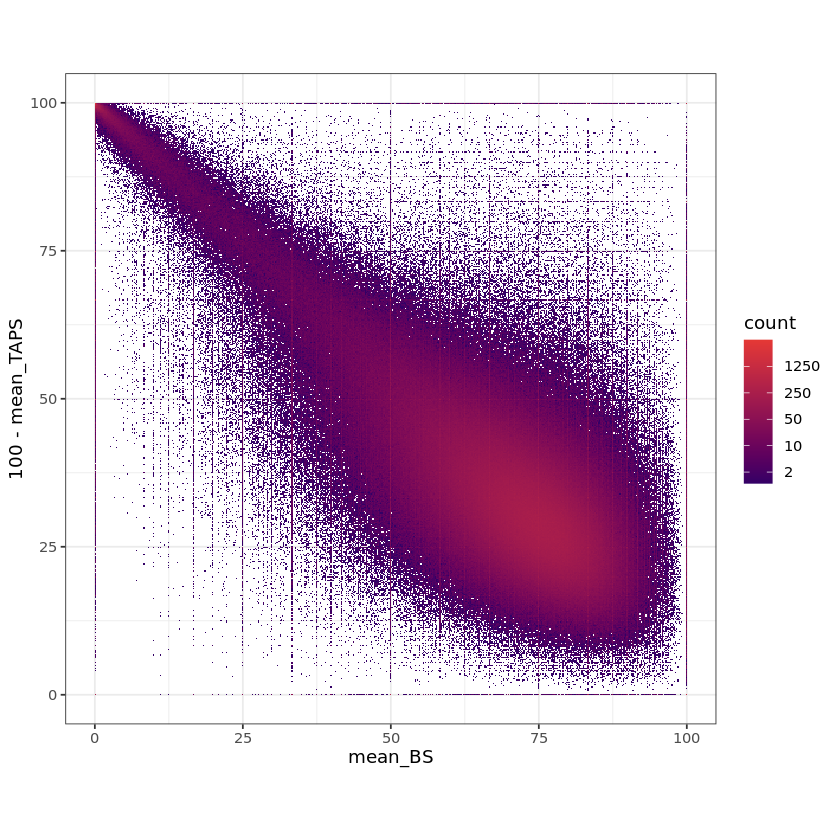

In [12]:
#make TAPS correlation plot 
my_breaks = c(2,10,50,250,1250)

p <- ggplot(data_corr_filt, aes(x=mean_BS,y=100-mean_TAPS)) + 
geom_bin_2d(bins = 500) +
theme_bw() + theme(aspect.ratio = 1) + 
scale_fill_gradient(name = "count", trans = "log", high = "#E53935", low = "#330066",
                        breaks = my_breaks, labels = my_breaks) 

p

In [13]:
#calculate correlation coefficients for reads C (displayed in Figure E9A)
cor(data_corr_filt$mean_BS,100-data_corr_filt$mean_TAPS)

[1] -0.7446054

# Extended Data Figure 9B

In [14]:
#mutate normalized TAPS value relative to BS
#Positive values: TAPS overestimate relative to BS. Negative Values: TAPS underestimate relative to BS
data_corr_filt <- data_corr_filt %>% mutate (normalized_TAPS = (mean_TAPS - mean_BS) / (mean_BS))

Warning message:
“Duplicated aesthetics after name standardisation: pad”Warning message:
“Removed 33104 rows containing non-finite values (stat_bin).”

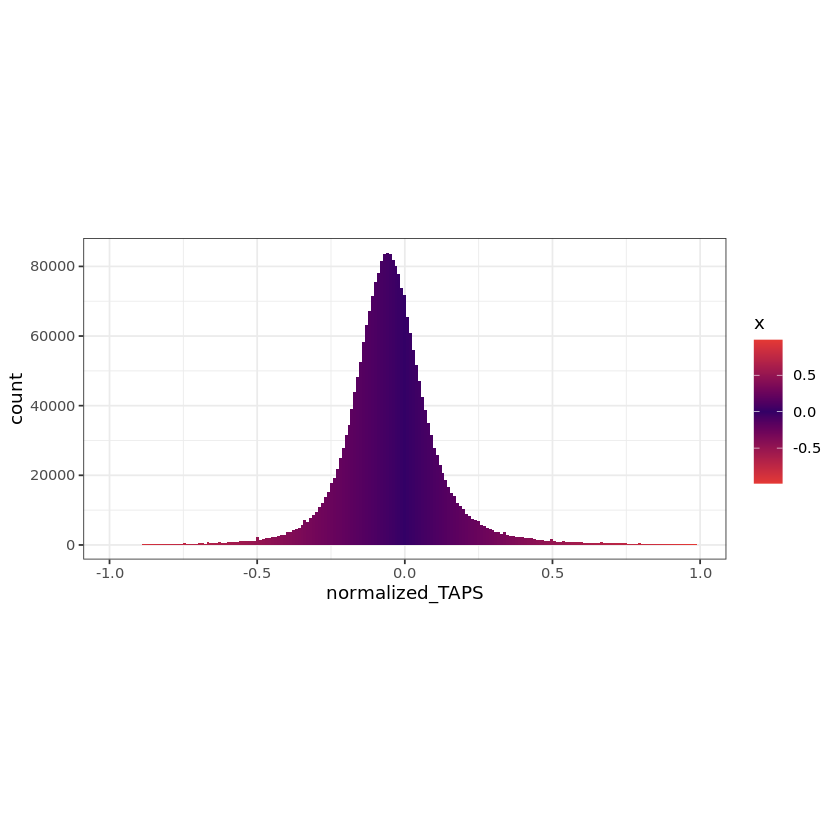

In [15]:
#create plot which shows how often TAPS underestimates or overestimates relative to BS-Seq
s <- ggplot(data_corr_filt, aes(x=normalized_TAPS, fill= ..x..)) + geom_histogram(bins = 200, pad = TRUE) + xlim(-.99,.99) + 
theme_bw() + theme(aspect.ratio = 0.5) + 
scale_fill_gradient2(high = "#E53935", mid = "#330066", low = "#E53935")

s

In [16]:
#calculate number of bins that are overestimated or underestimated
data_corr_filt <- data_corr_filt %>% mutate (normalized_TAPS_pos = case_when(normalized_TAPS >0 & normalized_TAPS != 1~"> zero", normalized_TAPS == 0 ~"zero", normalized_TAPS <0 & normalized_TAPS != -1~"< zero", TRUE ~ NA_character_))

Warning message in mean.default(data_corr_filt$normalized_TAPS_pos):
“argument is not numeric or logical: returning NA”

[1] NA

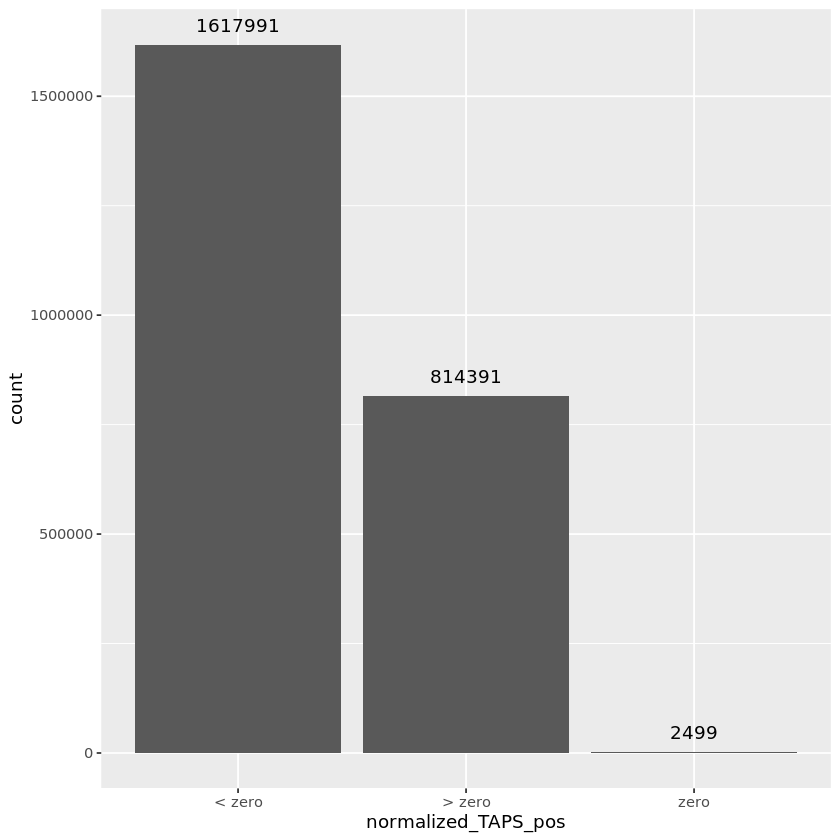

In [17]:
#display number of bins, used in E9B
s <- ggplot(data_corr_filt %>% filter(normalized_TAPS_pos != "NA"), aes(x=normalized_TAPS_pos)) + geom_bar() + geom_text(stat='count', aes(label=..count..), vjust=-1)
mean(data_corr_filt$normalized_TAPS_pos)
s


# Extended Data Figure 9C

Warning message:
“`show_guide` has been deprecated. Please use `show.legend` instead.”Warning message:
“Removed 12791 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 12791 rows containing non-finite values (stat_summary).”Warning message:
“Removed 12791 rows containing non-finite values (stat_summary).”

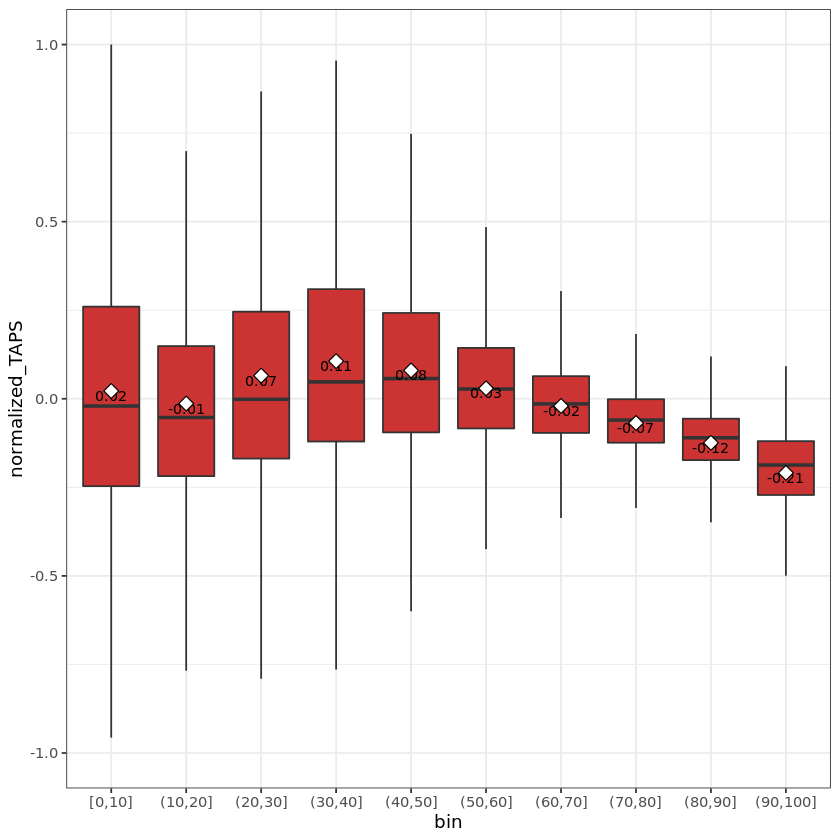

In [18]:
#create plot which shows bias of TAPS as a function of percent modification detected by BS
p <- data_corr_filt %>% filter (mean_BS != 0 & mean_BS != 100 & mean_TAPS != 0 & mean_TAPS != 100) %>%
  
  # Add a new column called 'bin': cut the initial 'carat' in bins
  mutate( bin=cut_width(mean_BS, width=10, boundary=0) ) %>%
  
  # plot
  ggplot( aes(x=bin, y=normalized_TAPS)) + geom_boxplot(outlier.shape = NA, fill = "#CC3333") + theme_bw() + ylim(-1,1) +  stat_summary(fun=mean, colour="black", geom="text", show_guide = FALSE, 
                                                                                                   vjust=1, size = 3, aes( label=round(..y.., digits=2))) + stat_summary(fun=mean, fill="white", geom="point", 
                                                                                                                         shape=23, size=3, show.legend=FALSE) + scale_fill_gradient2(high = "#E53935", low = "#330066")
p

# Imprinted Regions

We used the same ICRs as in our prior ACE-Seq manuscript. These ICRs were converted by LiftOver from mm10 to mm9. https://liftover.broadinstitute.org/

I first used the below bedtools intersect command in order to create the appropriate bedfile.

# Extended Data Figure 9D

In [19]:
#first calculate the mean of regions outside of the ICRs, displayed in E9D
mean(data_corr_filt$mean_BS)
mean(data_corr_filt$mean_TAPS)

[1] 67.77631

[1] 64.03562

In [20]:
#read in intersected bedfiles which show BS seq data within ICRs
#V1-V6 show BS-Seq data while V7-V9 show the location of the ICRs
file_BS <- read.csv('ICR_BS_mm9.bed',header=FALSE,sep='\t')
data_BS <- tbl_df(file_BS)
data_BS <- data_BS %>% mutate(V11 = "BS")

In [21]:
#read in intersected bedfiles which show TAPS data within ICRs
#V1-V6 show TAPS data while V7-V9 show the location of the ICRs
file_TAPS <- read.csv('ICR_TAPS_mm9.bed',header=FALSE,sep='\t')
data_TAPS <- tbl_df(file_TAPS)
data_TAPS <- data_TAPS %>% mutate(V11 = "TAPS")

In [22]:
# create new column that combines start and end of element = element_bin variable
data_temp <- bind_rows(data_BS, data_TAPS)
data_temp <- data_temp %>% mutate(across(V4,as.factor))
data_temp <- data_temp %>% mutate(element_bin = paste(V8, V9, sep=','))

In [23]:
# summarize count C and count T by element bin
data_temp <- data_temp %>% group_by(V11,V7,element_bin) %>% mutate(total_C_element_bin = sum(V5),
                                                                     total_T_element_bin = sum(V6)) 

In [24]:
# calculate percent modification for element bin
data_temp <- data_temp %>% mutate(perc_mod_element= (total_C_element_bin / (total_C_element_bin + total_T_element_bin))*100)

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”Warning message:
“`show_guide` has been deprecated. Please use `show.legend` instead.”

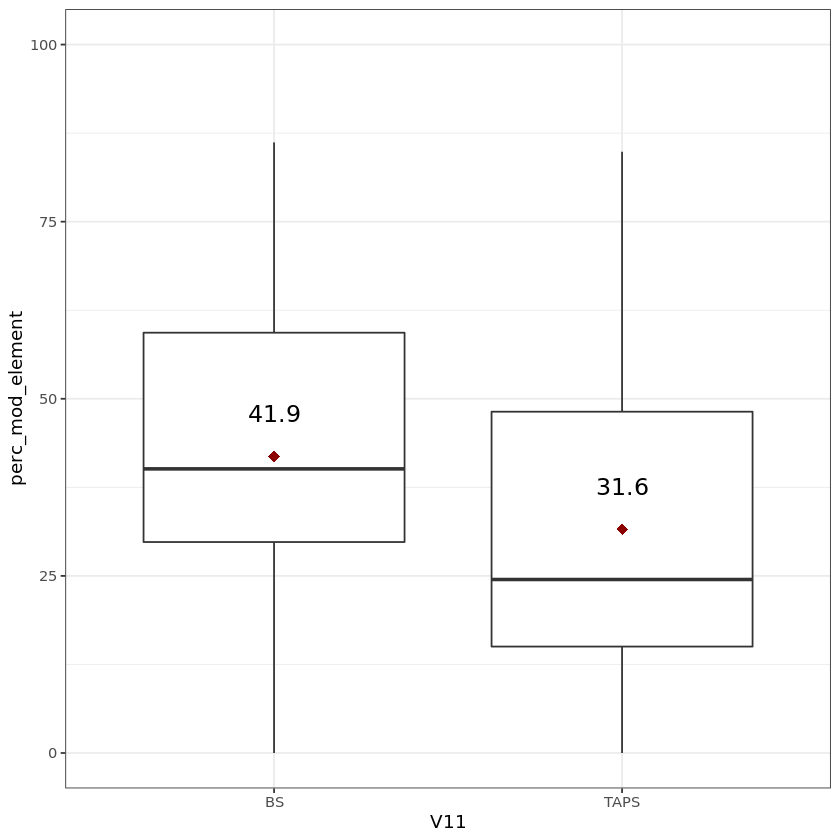

In [25]:
#create boxplot which shows the mean percent modification by TAPS and BS, displayed in E9D

p <- ggplot(data_temp, aes(x = V11, y = perc_mod_element, group = V11)) + geom_boxplot() + stat_summary(fun=mean, colour="darkred", geom="point", 
                                                                                                                    shape=18, size=3, show.legend=FALSE) + stat_summary(fun.y=mean, colour="black", geom="text", show_guide = FALSE, 
                                                                                                                                                                        vjust=-2, size = 5, aes( label=round(..y.., digits=1))) + theme_bw() + ylim(0,100)

p

Used deepTools commands below to make a heat map

make matrix file with BS and TAPS bigwig files as well as imprinted region bedfile

`computeMatrix scale-regions -S BS.bw TAPS.bw -R mm9_ICRs.bed -m 3000 -b 3000 -a 3000 -bs 300 -p "max/2" -o matrix_TAPS_BS_imprint.tab.gz`


plot heatmap

`plotHeatmap -m matrix_TAPS_BS_imprint.tab.gz -out matrix_TAPS_BS_imprint.pdf --missingDataColor .4 --heatmapHeight 10 --heatmapWidth 7 --plotTitle "Imprinted Regions" --whatToShow 'plot, heatmap and colorbar' --sortRegions ascend --sortUsing median --samplesLabel BS TAPS --sortUsingSamples 1 --colorMap Greys Reds --plotFileFormat 'pdf'`

# Extended Data Figure 9E

In [26]:
#join BS and TAPS imprinting regions data
data_group <- inner_join (data_BS,data_TAPS,by = c("V1","V2"))

In [27]:
#create new column that combines start and end of element = element bin variable
data_group <- data_group %>% mutate(element_bin = paste(V8.x, V9.x, sep=','))

In [28]:
#summarize count C and count T by element bin
data_group <- data_group %>% group_by(V7.x,element_bin) %>% mutate(BS_total_C_element_bin = sum(V5.x),
                                                                     BS_total_T_element_bin = sum(V6.x),
                                                                  TAPS_total_C_element_bin = sum(V5.y),
                                                                     TAPS_total_T_element_bin = sum(V6.y)) 


In [29]:
#calculate percent modification within each ICR
data_group <- data_group %>% group_by(V7.x,element_bin) %>% mutate(BS_bin_mod = BS_total_C_element_bin / (BS_total_C_element_bin+ BS_total_T_element_bin),
                                                                     TAPS_bin_mod = TAPS_total_C_element_bin / (TAPS_total_C_element_bin+ TAPS_total_T_element_bin))


In [30]:
#calculate size of each bin and CpGs covered
data_group <- data_group %>% mutate (size = V9.y-V8.y)
data_group <- data_group %>% mutate (bin_cov_BS = BS_total_C_element_bin+BS_total_T_element_bin)
data_group <- data_group %>% mutate (bin_cov_TAPS = TAPS_total_C_element_bin+TAPS_total_T_element_bin)

In [31]:
#summarize data to only show each value within each bin. Count CpGs in each bin.
data_summ <- data_group %>% group_by(V1,element_bin, BS_bin_mod, TAPS_bin_mod, size, bin_cov_BS, bin_cov_TAPS) %>% count()

In [32]:
#calculate CpG density within each ICR
data_summ <- data_summ %>% mutate (density = n / size)

In [33]:
#calculate normalized difference between TAPS and BS with same conventions as prior
data_summ <- data_summ %>% filter (BS_bin_mod != 0)
data_summ <- data_summ %>% mutate (normalized = (TAPS_bin_mod-BS_bin_mod) / (BS_bin_mod))

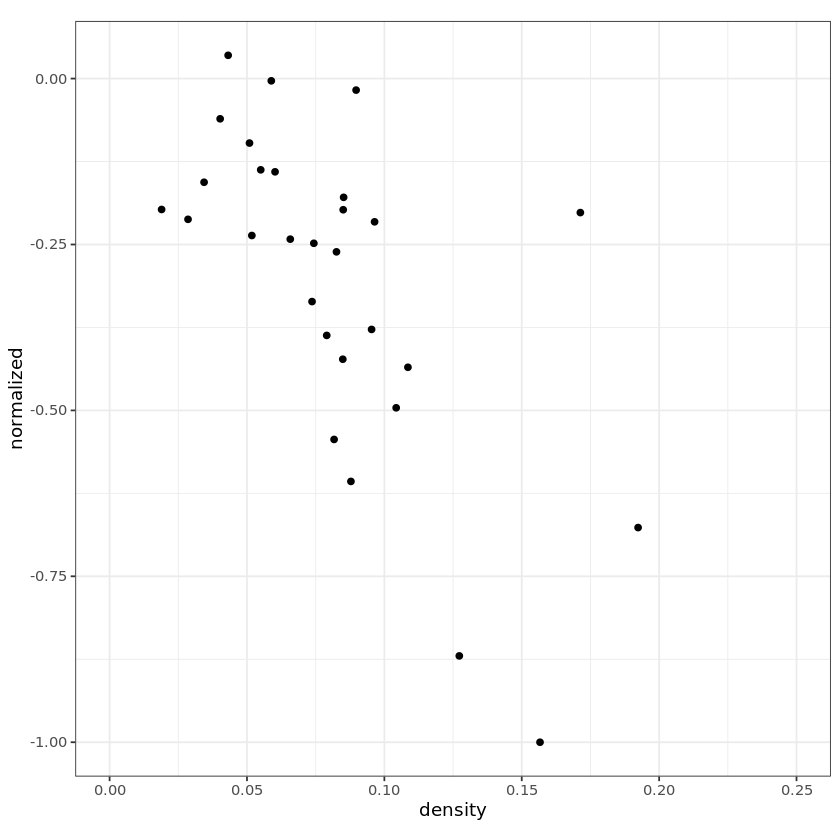

In [34]:
#graph TAPS deviation vs density
p <- ggplot(data_summ , aes(x = density, y = normalized)) + geom_point() + xlim(0,0.25) + 
theme_bw() + theme(aspect.ratio = 1)
p

In [35]:
cor(data_summ$density,data_summ$normalized)

[1] -0.6502523